In [1]:
# import requirements 
import requests
import re
import pandas as pd
import geopandas as gpd
from arcgis.gis import GIS
import os
import numpy as np
from arcgis.features import FeatureLayerCollection
from arcgis.features import FeatureSet, GeoAccessor
from arcgis.geometry import Geometry

In [31]:
#Import external files
governorate_municipality = gpd.read_file("C:/Users/joses/Desktop/UNEP_Gaza_Governorate_Municipality_Singleparts_POINTS.gpkg")
governorate_municipality = governorate_municipality.to_crs(epsg=4326)
governorate_municipality.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
#Read this to know more about how Kobo handles synchronous exports and where to find the right url
#https://support.kobotoolbox.org/synchronous_exports.html

#### FETCH KOBO DATA

# Authentication credentials
username = "guilherme_iablonovski"
password = "k0b0Senha"
export_token = "f72722c6ffe97db14144325853528a4b7a1c059b"

In [4]:
#Fuel Request API endpoint
kobo_api_url = "https://kf.kobotoolbox.org/api/v2/assets/aYyrjnacEdnBdZnXaxMcG5/export-settings/espkg4R8qBsuTeNUAUUmEzq"

In [5]:
def getKoboForm(url):
    # Create a session with authentication
    session = requests.Session()
    session.auth = (username, password)

    # Construct the export URL
    kobo_export_url = f"{url}/data.xlsx"#?format=csv&token={export_token}"

    # Fetch data using the authenticated session
    response = session.get(kobo_export_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Load data into a pandas DataFrame
        kobo_data = pd.read_excel(response.content)
        kobo_data.head()
        return kobo_data
    else:
        print("Error:", response.status_code)
        
kobo_data = getKoboForm(kobo_api_url)

C:\Users\joses\AppData\Local\Temp\ipykernel_6196\2076638761.py:15: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  kobo_data = pd.read_excel(response.content)


In [6]:
# Identifica as colunas que começam com "Please specify the municipality"
cols = [c for c in kobo_data.columns if c.startswith("Please specify the municipality")]

# Cria uma lista para armazenar os registros explodidos
records = []

# Itera sobre cada linha e coluna dessas
for _, row in kobo_data.iterrows():
    base_data = {col: row[col] for col in kobo_data.columns if col not in cols}  # mantém outras colunas

    for col in cols:
        val = row[col]
        if pd.isna(val):
            continue

        # Extrai o nome entre parênteses
        match = re.search(r'\((.*?)\)', col)
        governo = match.group(1).strip() if match else ''

        # Divide as respostas usando ". " como separador
        municipios = re.split(r'(?<=\.)\s+', str(val).strip())

        # Limpa e forma a nova lista com "Governo_Município"
        for m in municipios:
            m = m.strip().rstrip('.')
            if m:
                new_row = base_data.copy()
                new_row['Gov_Mun'] = f"{governo}_{m}"
                records.append(new_row)

# Cria o novo DataFrame com as linhas expandidas
kobo_data_exploded = pd.DataFrame(records).reset_index(drop=True)
kobo_data_exploded

,This note can be read out loud,Please fill in this form if you represent a non-government organisation requesting fuel for debris removal purposes.,Implementing agency,Please specify,Contact person name,Contact person phone number,Contact person email address,Do you have a MoU with UNOPS?,Location of planned intervention(s),Type of site,...,_uuid,_submission_time,_validation_status,_notes,_status,_submitted_by,__version__,_tags,_index,Gov_Mun
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deir Al-Balah,Road,...,5e99250e-4ebf-401b-b913-344d9b453967,2025-07-02 13:43:58,NaN,NaN,submitted_via_web,NaN,vrUo2zbbGfNkhDf8V63RcD,NaN,1,Deir Al-Balah_Deir al Balah
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Khan Younis,Road,...,b3021b66-fc42-441a-bd1f-a8704aadc8d1,2025-07-03 06:33:49,NaN,NaN,submitted_via_web,NaN,vrUo2zbbGfNkhDf8V63RcD,NaN,2,Khan Younis_Khan Yunis
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deir Al-Balah Khan Younis,Road,...,c9d9d7dc-3feb-49fc-9a92-67af1172e501,2025-09-09 07:08:43,NaN,NaN,submitted_via_web,NaN,vn3LwfJj9CHwtUAVPUauxa,NaN,3,Deir Al-Balah_Deir al Balah
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deir Al-Balah Khan Younis,Road,...,c9d9d7dc-3feb-49fc-9a92-67af1172e501,2025-09-09 07:08:43,NaN,NaN,submitted_via_web,NaN,vn3LwfJj9CHwtUAVPUauxa,NaN,3,Khan Younis_Khan Yunis
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gaza North Gaza,Road,...,98abb206-0760-4eff-add7-9b2f3b662bd1,2025-10-11 15:38:18,NaN,NaN,submitted_via_web,NaN,vaY28MWx3PuyJsMiDtRXix,NaN,4,Gaza_Gaza
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gaza North Gaza,Road,...,98abb206-0760-4eff-add7-9b2f3b662bd1,2025-10-11 15:38:18,NaN,NaN,submitted_via_web,NaN,vaY28MWx3PuyJsMiDtRXix,NaN,4,North Gaza_Beit Lahiya
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gaza North Gaza,Road,...,98abb206-0760-4eff-add7-9b2f3b662bd1,2025-10-11 15:38:18,NaN,NaN,submitted_via_web,NaN,vaY28MWx3PuyJsMiDtRXix,NaN,4,North Gaza_Jabalya
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gaza Khan Younis North Gaza,Road,...,110bdf70-e4a5-44ee-9911-91a1bb328b19,2025-10-17 10:32:21,NaN,NaN,submitted_via_web,NaN,v9j7GrtCx8DU3Tgt3p5HED,NaN,5,Gaza_Ash Shati' Camp
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gaza Khan Younis North Gaza,Road,...,110bdf70-e4a5-44ee-9911-91a1bb328b19,2025-10-17 10:32:21,NaN,NaN,submitted_via_web,NaN,v9j7GrtCx8DU3Tgt3p5HED,NaN,5,Gaza_Gaza
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gaza Khan Younis North Gaza,Road,...,110bdf70-e4a5-44ee-9911-91a1bb328b19,2025-10-17 10:32:21,NaN,NaN,submitted_via_web,NaN,v9j7GrtCx8DU3Tgt3p5HED,NaN,5,Khan Younis_Khan Yunis


In [7]:
#### INITIAL CLEANING

#Standardize data for municipalities without neighborhoods

def standardize(df):

    kobo_data_0 = df.replace(0, None)  
    return kobo_data_0

kobo_data_exploded = standardize(kobo_data_exploded)

<Axes: >

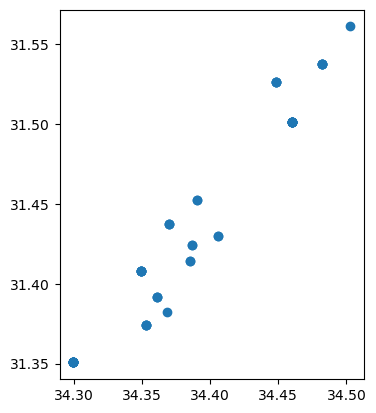

In [9]:
# Faz o join com o gdf, mantendo todos os municípios originais

gdf_filtrado = governorate_municipality.merge(kobo_data_exploded, on='Gov_Mun', how='inner')
gdf_filtrado.plot()

In [10]:
#Handle columns so they are not modified by arcgis when uploaded
def makeArcGISfriendly(df):
    df.columns = df.columns.str.replace(r"[ ]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[.]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[?]", "_", regex=True)
    df.columns = df.columns.str.replace(r"[']", "", regex=True)
    df.columns = df.columns.str.replace(r"[(]", "", regex=True)
    df.columns = df.columns.str.replace(r"[)]", "", regex=True)
    df.columns = df.columns.str.replace(r"[[]", "", regex=True)
    df.columns = df.columns.str.replace(r"[]]", "", regex=True)
    df.columns = df.columns.str.replace(r"[%]", "_", regex=True)
    df.columns = map(str.lower, df.columns)
    
    # Remove leading underscores
    df = df.rename(columns={
        '_id':'f_id',
        '_uuid':'f_uuid',
    })
    df.columns = df.columns.str.lstrip('_')
    
    #Truncate and ensure uniqueness
    seen = {}
    final_cols = []
    max_length = 31
    for col in df.columns:
        base = col[:max_length]
        new_col = base
        i = 1
        while new_col in seen:
            suffix = f"_{i}"
            trim_len = max_length - len(suffix)
            new_col = base[:trim_len] + suffix
            i += 1
        seen[new_col] = True
        final_cols.append(new_col)
    
    # Step 4: Apply to DataFrame
    df.columns = final_cols
    return df

gdf_exploded = makeArcGISfriendly(gdf_filtrado)

c:\Users\joses\anaconda3\Lib\site-packages\pandas\core\strings\object_array.py:172: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


In [11]:
def simplifyGeometries(df):
    df['geometry'] = df['geometry'].centroid
    return df
    
gdf_exploded = simplifyGeometries(gdf_exploded)

C:\Users\joses\AppData\Local\Temp\ipykernel_6196\3003421674.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['geometry'] = df['geometry'].centroid


In [12]:
seen = set()
unique_flags = []

for _, row in gdf_exploded.iterrows():
    if row['f_id'] in seen:
        unique_flags.append('')
    else:
        unique_flags.append('yes')
        seen.add(row['f_id'])

gdf_exploded['unique_'] = unique_flags

In [14]:
#Run locally and upload manually to ArcGIS the first time!
gdf_exploded.to_file("C:/Users/joses/Desktop/DWG_Gaza_Fuel_Requests_Responses.gpkg")

In [15]:
#### UPDATE DATA IN ARCGIS

#Connect to the ArcGIS Enterprise portal

gis = GIS('https://wesrmapportal.unep.org/portal/', 'h.partow', 'R&Runit2024')

In [16]:
# Access the feature-layer through its URL
file = "https://wesrmapportal.unep.org/arcgis/rest/services/Hosted/DWG_Gaza_Fuel_Requests_Responses/FeatureServer"

In [25]:
# Access the feature-layer through its URL
fuel_file = 'DWG_Gaza_Fuel_RequestsResponses'


def searchArcgis(keyword):
    if not isinstance(keyword, str):
        raise TypeError(f"Esperado 'str' em 'keyword', recebido {type(keyword)} → {keyword}")
    results = gis.content.search(f'title:\"{keyword}\"', item_type="Feature Layer")
    if not results:
        print("Nenhum resultado encontrado para", keyword)
        return None
    results_sorted = sorted(results, key=lambda x: x.modified, reverse=True)
    return results_sorted[0]

search_fuel = searchArcgis(fuel_file)

display(search_fuel)

<Item title:"DWG_Gaza_Fuel_RequestsResponses" type:Feature Layer Collection owner:h.partow>

In [27]:
def updateFeature(search_results, gdf):

    item = gis.content.get(search_results.id)

    flc = FeatureLayerCollection.fromitem(item)
    layer = flc.layers[0]  # Assuming you're working with the first layer


    # Step 1: Truncate features
    truncate_result = layer.manager.truncate()
    print("Truncate result:", truncate_result)

    # Keep only matching columns
    expected_fields = [f["name"] for f in layer.properties.fields if f["name"] != "fid"]
    gdf = gdf[[col for col in gdf.columns if col in expected_fields or col == "geometry"]]

    gdf = gdf.to_crs(epsg=4326)

    sedf = GeoAccessor.from_geodataframe(gdf)

    fs = FeatureSet.from_dataframe(sedf)

    result = layer.edit_features(adds=fs.features)
    print("Result:", result)
    return(result)

updateFeature(search_fuel, gdf_exploded)

Truncate result: {'success': True}
Result: {'addResults': [{'success': True, 'objectId': 1}, {'success': True, 'objectId': 2}, {'success': True, 'objectId': 3}, {'success': True, 'objectId': 4}, {'success': True, 'objectId': 5}, {'success': True, 'objectId': 6}, {'success': True, 'objectId': 7}, {'success': True, 'objectId': 8}, {'success': True, 'objectId': 9}, {'success': True, 'objectId': 10}, {'success': True, 'objectId': 11}, {'success': True, 'objectId': 12}, {'success': True, 'objectId': 13}, {'success': True, 'objectId': 14}, {'success': True, 'objectId': 15}, {'success': True, 'objectId': 16}, {'success': True, 'objectId': 17}, {'success': True, 'objectId': 18}, {'success': True, 'objectId': 19}, {'success': True, 'objectId': 20}, {'success': True, 'objectId': 21}, {'success': True, 'objectId': 22}, {'success': True, 'objectId': 23}, {'success': True, 'objectId': 24}, {'success': True, 'objectId': 25}, {'success': True, 'objectId': 26}, {'success': True, 'objectId': 27}, {'suc

{'addResults': [{'success': True, 'objectId': 1},
  {'success': True, 'objectId': 2},
  {'success': True, 'objectId': 3},
  {'success': True, 'objectId': 4},
  {'success': True, 'objectId': 5},
  {'success': True, 'objectId': 6},
  {'success': True, 'objectId': 7},
  {'success': True, 'objectId': 8},
  {'success': True, 'objectId': 9},
  {'success': True, 'objectId': 10},
  {'success': True, 'objectId': 11},
  {'success': True, 'objectId': 12},
  {'success': True, 'objectId': 13},
  {'success': True, 'objectId': 14},
  {'success': True, 'objectId': 15},
  {'success': True, 'objectId': 16},
  {'success': True, 'objectId': 17},
  {'success': True, 'objectId': 18},
  {'success': True, 'objectId': 19},
  {'success': True, 'objectId': 20},
  {'success': True, 'objectId': 21},
  {'success': True, 'objectId': 22},
  {'success': True, 'objectId': 23},
  {'success': True, 'objectId': 24},
  {'success': True, 'objectId': 25},
  {'success': True, 'objectId': 26},
  {'success': True, 'objectId': 2